In [ ]:
### Calculate workday daily mean traffic volume over each year

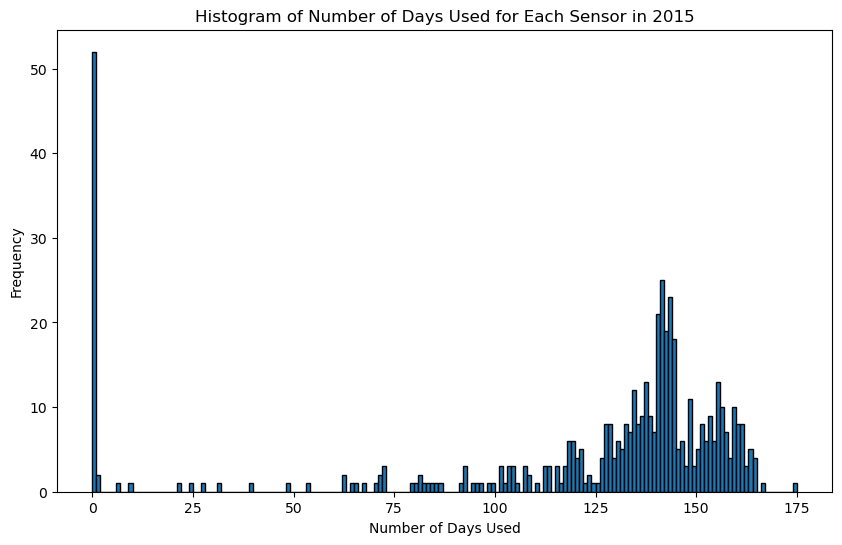

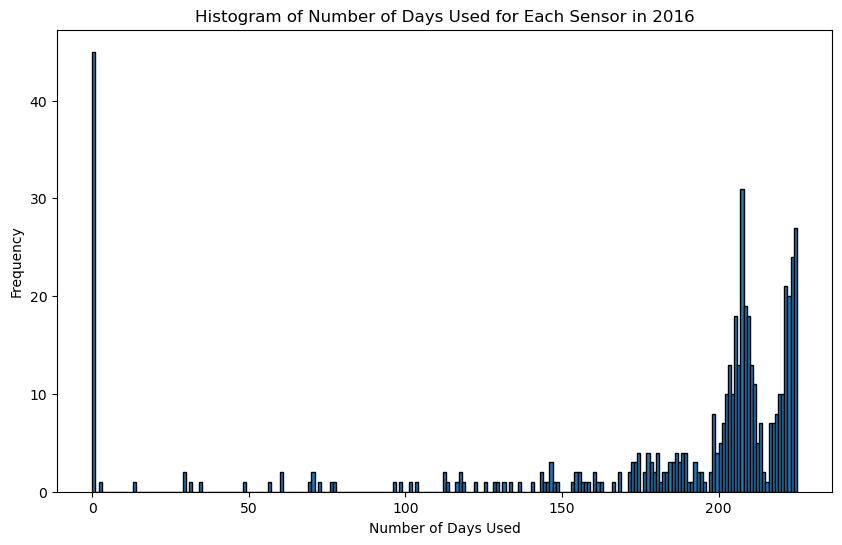

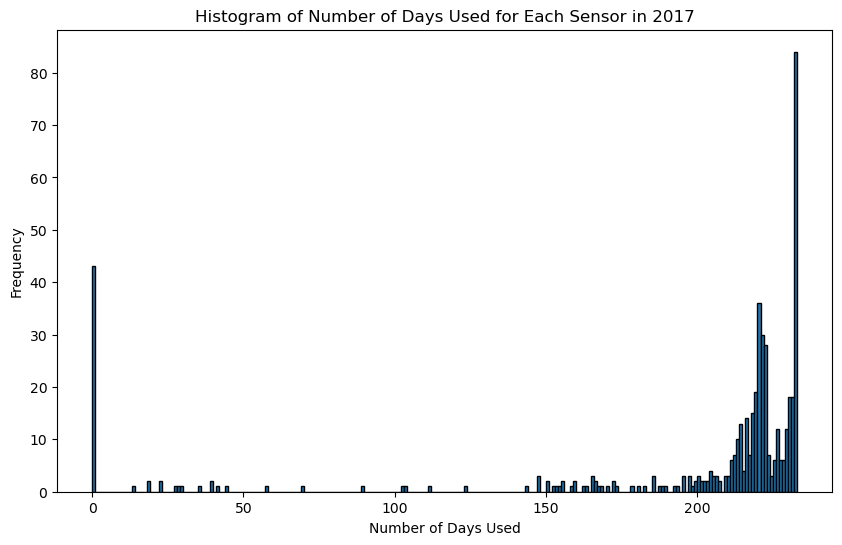

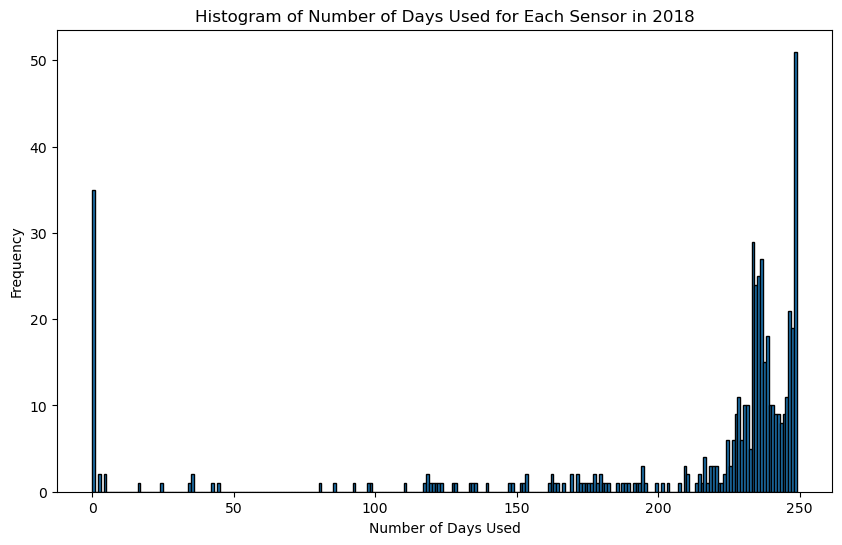

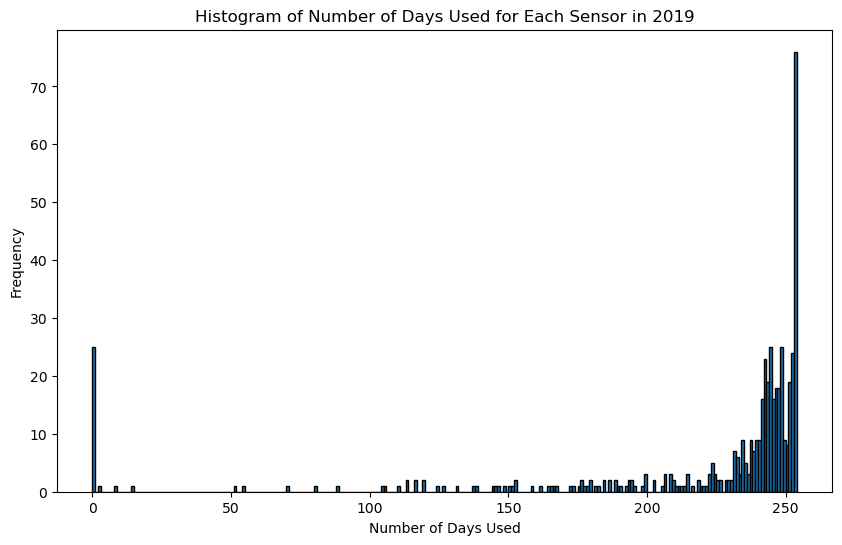

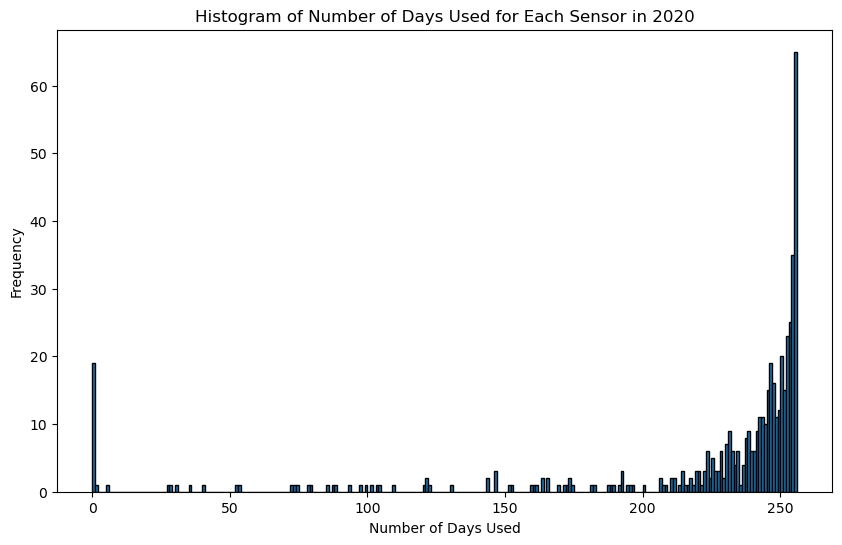

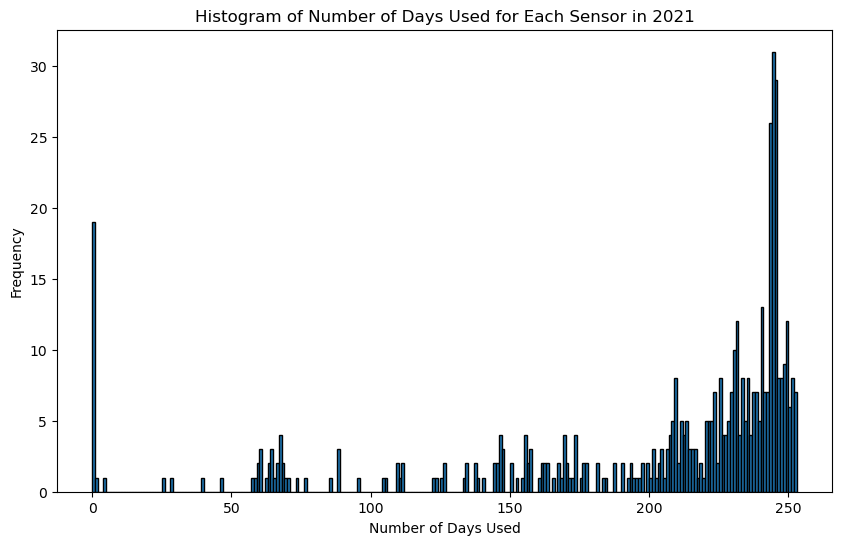

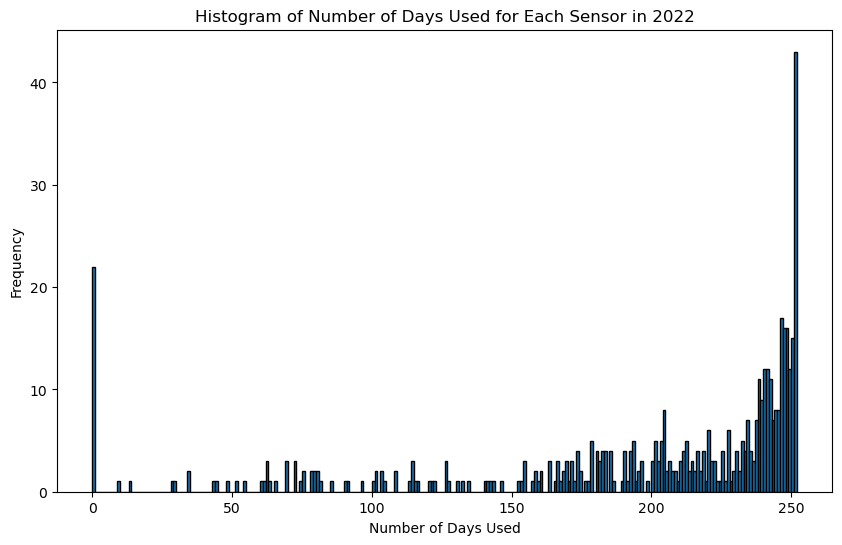

In [20]:
import tensorflow as tf
import h5py
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store average daily volumes for each year
average_daily_volumes_per_year = {}

# Loop through each year from 2015 to 2022
for year in range(2015, 2023):
    # print(f"Processing year: {year}")

    # Load data for the current year
    with h5py.File(f'Highway_2015-2023_498sensors/sensor498_{year}-01-01_{year}-12-31.h5', 'r') as f:  
        data = tf.convert_to_tensor(f['data'][:])  
        sites = tf.convert_to_tensor(f['sites'][:]) 
        timestamps = tf.convert_to_tensor(f['timestamps'][:]) 

    # 1. Extract the traffic volume data
    traffic_volume = data[:, :, 1].numpy()  # Shape: (498, 35040)

    # 2. Convert timestamps to pandas datetime for grouping
    timestamps_pd = pd.to_datetime(timestamps.numpy().astype(str))

    # 3. Create a pandas DataFrame to group by date
    df = pd.DataFrame(traffic_volume.T, index=timestamps_pd, columns=sites.numpy())  # Transpose to make time index

    # 4. Remove weekends
    df = df[~df.index.weekday.isin([5, 6])]  # 5 is Saturday, 6 is Sunday

    # 5. Remove bank holidays using the holidays package
    uk_holidays = holidays.UK(years=year)
    bank_holidays = pd.to_datetime(list(uk_holidays.keys()))
    df = df[~df.index.floor('D').isin(bank_holidays)]  # Remove rows corresponding to bank holidays

    # 6. Calculate total daily volume for each sensor and check for NaNs
    daily_totals = df.resample('D').sum()  # Sum every 24 hours
    daily_counts = df.resample('D').count()  # Count non-NaN entries to identify full days

    # 7. Exclude days with NaNs
    daily_totals = daily_totals[daily_counts == 96]  # 96 intervals of 15 minutes in a day

    # 8. Calculate the average daily volume for each sensor
    average_daily_volume = daily_totals.mean(axis=0)  # Average across days for each sensor

    # 9. Calculate the number of days used for each sensor
    num_days_used = daily_totals.notna().sum(axis=0)
    # print(f"Number of days used for each sensor in {year}:")
    # print(num_days_used)
    plt.figure(figsize=(10, 6))
    plt.hist(num_days_used, bins=range(0, num_days_used.max() + 1), edgecolor='black')
    plt.title(f'Histogram of Number of Days Used for Each Sensor in {year}')
    plt.xlabel('Number of Days Used')
    plt.ylabel('Frequency')
    plt.show()

    # 10. Store the average daily volume for the year in a dictionary
    average_daily_volumes_per_year[year] = tf.convert_to_tensor(average_daily_volume.values)


In [21]:
average_daily_volumes_list = [average_daily_volumes_per_year[year] for year in range(2015, 2023)]
average_daily_volumes_tensor = tf.convert_to_tensor(np.stack(average_daily_volumes_list), dtype=tf.float32)


In [25]:
# Load the new order of sensor IDs from the CSV file
sensors_df = pd.read_csv('Highway_2015-2023_498sensors/sensors_498.csv')
new_order = sensors_df['Id'].values  # New order from the CSV

# Create a mapping from sites to the new order
sites_array = np.array(sites, dtype=int)  # Convert sites to a NumPy array
reordering_indices = [np.where(sites_array == sensor_id)[0][0] for sensor_id in new_order]


In [27]:
reordered_tensor = tf.gather(average_daily_volumes_tensor, reordering_indices, axis=1)

In [29]:

# Verify the shape of the reorganized tensor
print(f"Reorganized tensor shape: {reordered_tensor.shape}")  # Should still print (8, 498)

# Save the tensor to an HDF5 file
with h5py.File('average_daily_volumes_2015-2022.h5', 'w') as h5f:
    h5f.create_dataset('data', data=reordered_tensor.numpy())

print("Reordered tensor saved successfully to average_daily_volumes_2015_2022.h5")

Reorganized tensor shape: (8, 498)
Reordered tensor saved successfully to average_daily_volumes_2015_2022.h5


In [28]:
# Check for NaNs and calculate their statistics
num_years, num_sensors = average_daily_volumes_tensor.shape

# Iterate over each year and calculate the number and percentage of NaNs
for year_idx in range(num_years):
    year_data = average_daily_volumes_tensor[year_idx]
    
    # Calculate the number of NaNs
    num_nans = tf.reduce_sum(tf.cast(tf.math.is_nan(year_data), tf.int32)).numpy()
    
    # Calculate the percentage of NaNs
    percentage_nans = (num_nans / num_sensors) * 100
    
    # Print the results for the year
    year = 2015 + year_idx
    print(f"Year {year}: {num_nans} NaNs, {percentage_nans:.2f}%")

Year 2015: 52 NaNs, 10.44%
Year 2016: 45 NaNs, 9.04%
Year 2017: 43 NaNs, 8.63%
Year 2018: 35 NaNs, 7.03%
Year 2019: 25 NaNs, 5.02%
Year 2020: 19 NaNs, 3.82%
Year 2021: 19 NaNs, 3.82%
Year 2022: 22 NaNs, 4.42%


In [282]:
def get_sensor_position():
    """
    Map nodes to grid cells.
    Output: array of shape (181, 2) where each entry contains the row and col (position on the grid) for each node.
    """
    
    nodes_df = pd.read_csv("Highway_2015-2023_498sensors/tris_node_features.csv")
    # Convert latitude and longitude to shapely Point objects
    nodes_gdf = gpd.GeoDataFrame(
        nodes_df,
        geometry=gpd.points_from_xy(nodes_df.Longitude, nodes_df.Latitude),
        crs='EPSG:4326'
    )

    grid_gdf = gpd.read_file('grid/grid_cells.shp')
    
    # Convert grid to the same CRS
    grid_gdf = grid_gdf.to_crs(nodes_gdf.crs)
    
    # Perform a spatial join to find which grid cell each sensor belongs to
    sensors_with_grid = gpd.sjoin(nodes_gdf, grid_gdf, how="left", predicate="within")

    grid_shape = (653, 574)
    sensors_with_grid['row'] = sensors_with_grid['index_right'] // grid_shape[1]
    sensors_with_grid['col'] = sensors_with_grid['index_right'] % grid_shape[1]

    sensor_positions = sensors_with_grid[['row', 'col']].to_numpy()
    
    return sensor_positions

In [283]:
position = get_sensor_position()

In [287]:
position.shape

(181, 2)

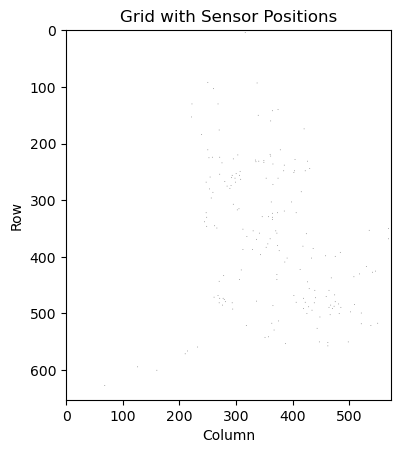

In [286]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grid(sensor_positions, grid_shape):
    """
    Plot the grid and highlight sensor positions.

    Parameters:
    sensor_positions : numpy.ndarray
        Array of shape (181, 2) containing the row and col positions of sensors.
    grid_shape : tuple
        Shape of the grid as (num_rows, num_cols).
    """
    # Create an empty grid
    grid = np.zeros(grid_shape)

    # Mark the sensor positions in the grid
    for pos in sensor_positions:
        row, col = pos
        grid[row, col] = 1  # Mark sensor position as 1 (white)

    # Plot the grid
    # plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray_r')  # 'gray_r' reverses the gray colormap (0 is black, 1 is white)
    plt.title('Grid with Sensor Positions')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

# Example usage:
# Assuming sensor_positions is your array of shape (181, 2)
# And grid_shape is the shape of your grid, for example (100, 100)

grid_shape = (653, 574)  # Replace with your actual grid dimensions
plot_grid(position, grid_shape)
